This is a version of object detection that goes through the thought process more in depth.

##### Step 1. Loading the Input image/s

In [1]:
# import dependencies 
import os 
os.environ ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1500"

# SAM/OpenCLIP dependencies
import torch
import torchvision
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image as Image_Open
from PIL import Image
import open_clip

# COCO dependencies
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import json

Load COCO and initialize the labels from Val 2017 annotations

In [2]:
# Loading COCO
dataDir='..'
dataType='val2017'
annFile='{}/coco/annotations/instances_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

# display COCO categories and store them into array 'labels'. Tokenize the labels using OpenCLIP
cats = coco.loadCats(coco.getCatIds())
labels = [(cat['id'], cat['name']) for cat in cats]
labels_id = {id : label for id, label in labels}
print(labels_id)

# Tokenize the labels
labels_tokenized = open_clip.tokenize(["This is " + desc[1] for desc in labels])

loading annotations into memory...
Done (t=1.25s)
creating index...
index created!
{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73

Load input image using COCO

In [26]:
def load_COCO_image():
    # randomly sample an image from COCO Val split 2017
    catIds = coco.getCatIds(catNms=['dog']);
    imgIds = coco.getImgIds(catIds=catIds );

    # imgIds = coco.getImgIds(imgIds = [324158]) // uncomment to get a specific image
    img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
    image_id = img['id']

    # load and display image
    image = io.imread(img['coco_url']) 

    # tempImg to be cropped for some functions
    tempImg = Image.fromarray(image) 

    plt.imshow(tempImg)
    plt.axis('off')
    plt.show()
    return image, image_id, tempImg

Load input image locally

In [ ]:
def load_local_image():
    # load and display image
    image = cv2.imread('images/dog.jpg') 
    image_id = 99999999
    # convert image to be readable by SAM
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    from PIL import Image

    # tempImg to be cropped for some functions
    tempImg = Image.fromarray(image)
    plt.imshow(image)
    plt.axis('off')
    plt.show() 
    return image, image_id, tempImg

##### Step 2. Segment Anything Output

In [4]:
# Loading SAM Model
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Loading SAM Predictors
mask_generator = SamAutomaticMaskGenerator(
    model = sam,
    points_per_side = 32,
    points_per_batch = 64,
    pred_iou_thresh = 0.95,
    stability_score_thresh = 0.95,
    stability_score_offset = 1.0,
    box_nms_thresh = 0.7,
    crop_n_layers = 0,
    crop_nms_thresh = 0.7,
    crop_overlap_ratio = 100 / 2500,
    crop_n_points_downscale_factor = 2,
    point_grids = None,
    min_mask_region_area = 400,
    output_mode = "binary_mask",
) # automatic
predictor = SamPredictor(sam) # manual

# Loading OpenCLIP model
model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

In [12]:
# functions for displaying mask/box
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)   
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [27]:
def generate_masks(image):
    # Run automatic mask generation
    masks = mask_generator.generate(image)
    length_masks = len(masks)
    return masks, length_masks

In [29]:
def decode_image():
    # generate model for whole image using OpenCLIP and normalize text features
    display_image = tempImg.convert("RGB")
    image_unsqueezed = transform(display_image).unsqueeze(0)

    with torch.no_grad(), torch.cuda.amp.autocast():
        generated = model.generate(image_unsqueezed)
        text_features = model.encode_text(labels_tokenized).float() # initialize text features
        
    text_features /= text_features.norm(dim=-1, keepdim=True) # normalizing text features
        
    decoded = open_clip.decode(generated[0]).split("<end_of_text>")[0].replace("<start_of_text>", "")
    return text_features, decoded

##### Step 3. Cropping the image depending on the SAM output (masks)

In [7]:
# function for cropping images
def get_cropped_image(mask):
    # convert the XYWH bounding box to LURD format
    bbox_xywh = masks[mask]['bbox'] # the SAM model returns the bounding box in xywh format
    bbox_lurd = [bbox_xywh[0], bbox_xywh[1], bbox_xywh[0] + bbox_xywh[2], 
    bbox_xywh[1] + bbox_xywh[3]] # convert the bounding box to LURD format
    
    # Crop the image using the bounding box coordinates
    cropped_image = tempImg.crop(bbox_lurd) 
    display_image = cropped_image.convert("RGB")
    cropped_image = transform(display_image).unsqueeze(0)
    
    return cropped_image, display_image

##### Step 4. Getting the output label prediction from openCLIP.

In [8]:
# function to run through all the masks and then crop image to ask OpenClip "This is a photo of what?"
def get_mask_label(mask):    
    # crop the image AKA get the bounding box
    cropped_image, display_image = get_cropped_image(mask)
    
    # ask OpenClip "This is a photo of what?"
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(cropped_image).float()
        cropped_decoded = model.generate(cropped_image)
    
    # Normalize the features and calculate the dot product of each pair.
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    
    # Get the predicted label
    predicted_label_index = similarity.argmax()
    predicted_label = labels[predicted_label_index]
    
    # get the top 2 probabilities and labels
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(1, dim=-1)
    
    cropped_decoded = open_clip.decode(cropped_decoded[0]).split("<end_of_text>")[0].replace("<start_of_text>", "")
    
    # return the highest probability label and its percentage
    return labels[top_labels[0][0].item()], top_probs[0][0].item(), cropped_decoded

In [30]:
# create a dictionary of labels and the corresponding probabilities
def create_dict():
    label_dict = []
    generated_dict = []

    # iterate through all the masks and get the top 2 labels for each mask
    for mask in range(length_masks):
        label, probability, cropped_decoded = get_mask_label(mask)
        if label[1] in decoded or label[1] in cropped_decoded:
            label_dict.append({"image_id": image_id, "category_id": label[0], 
                            "bbox": masks[mask]['bbox'], "score": probability,
                            "point_coords": masks[mask]['point_coords']
                            })
            generated_dict.append(cropped_decoded)
    return label_dict, generated_dict

In [12]:
# check validity of labels by printing them out
def check_label(label_id):
      bbox_xywh = label_dict[label_id]['bbox']
      # Convert the bounding box to LURD format
      bbox_lurd = [bbox_xywh[0], bbox_xywh[1], bbox_xywh[0] + bbox_xywh[2],bbox_xywh[1] + bbox_xywh[3]]
      print("label: ", label_dict[label_id]["category_id"], ",", 
            labels_id.get(label_dict[label_id]["category_id"]), 
            "score: ", round(label_dict[label_id]["score"], 3))
      print("point_coords: ", label_dict[label_id]["point_coords"])
      # only print generated_dict every 2nd time
      # if label_id % 2 == 0:   
      print("generated: ", generated_dict[label_id])
      cropped_image = tempImg.crop(bbox_lurd) # Crop the image using the bounding box coordinates
      cropped_image.convert("RGB")
      plt.figure(figsize=(5,5))
      plt.imshow(cropped_image)
      plt.axis('off')
      plt.show() 

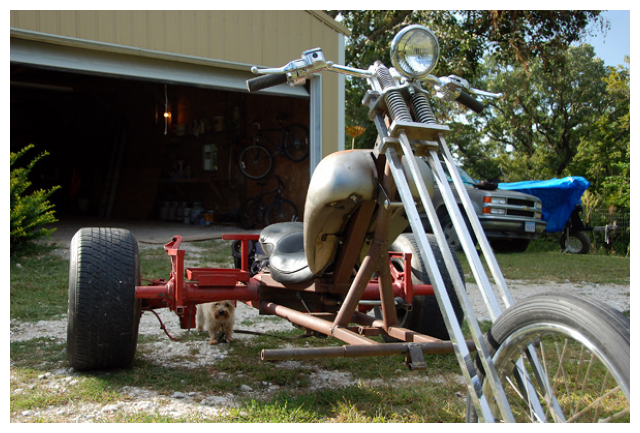

Image ID: 7386
Number of masks: 54
Image description: a dog standing in front of an old motorcycle . 
[{'image_id': 7386, 'category_id': 8, 'bbox': [472, 161, 89, 54], 'score': 0.9486284852027893, 'point_coords': [[553.125, 168.75]]}, {'image_id': 7386, 'category_id': 62, 'bbox': [241, 206, 52, 58], 'score': 0.8997074961662292, 'point_coords': [[253.125, 243.75]]}, {'image_id': 7386, 'category_id': 85, 'bbox': [222, 130, 31, 33], 'score': 0.9551718831062317, 'point_coords': [[234.375, 156.25]]}, {'image_id': 7386, 'category_id': 3, 'bbox': [229, 63, 38, 16], 'score': 0.19169601798057556, 'point_coords': [[234.375, 68.75]]}, {'image_id': 7386, 'category_id': 18, 'bbox': [181, 281, 35, 42], 'score': 0.9677563905715942, 'point_coords': [[196.875, 293.75]]}, {'image_id': 7386, 'category_id': 8, 'bbox': [473, 161, 113, 75], 'score': 0.9938992261886597, 'point_coords': [[534.375, 181.25]]}, {'image_id': 7386, 'category_id': 2, 'bbox': [0, 0, 327, 203], 'score': 0.5265945792198181, 'point_coo

In [31]:
image, image_id, tempImg = load_COCO_image()
print("Image ID:", image_id)
masks, length_masks = generate_masks(image)
print("Number of masks:", length_masks)
text_features, decoded = decode_image()
print("Image description:", decoded)
label_dict, generated_dict = create_dict()
print(label_dict)

label:  8 , truck score:  0.9486284852027893
point_coords:  [[553.125, 168.75]]
generated:  a blue tarp covering a truck parked on the side of the road . 


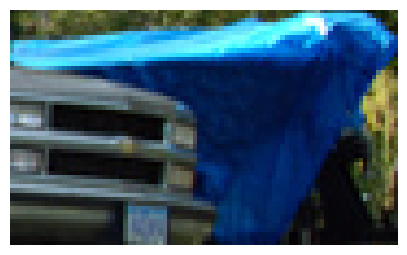

label:  62 , chair score:  0.8997074961662292
point_coords:  [[253.125, 243.75]]
generated:  a close - up view of a silver chair . 


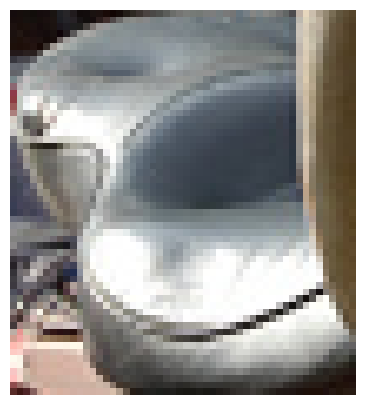

label:  85 , clock score:  0.9551718831062317
point_coords:  [[234.375, 156.25]]
generated:  an image of a clock with a dark background . 


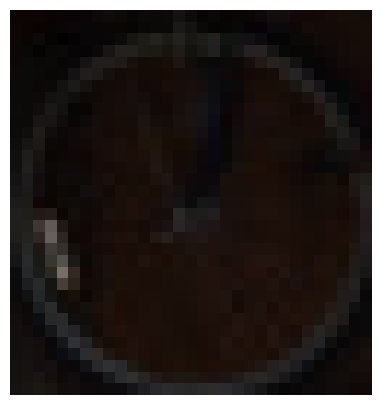

label:  3 , car score:  0.19169601798057556
point_coords:  [[234.375, 68.75]]
generated:  a blurry image of a car in the middle of a road . 


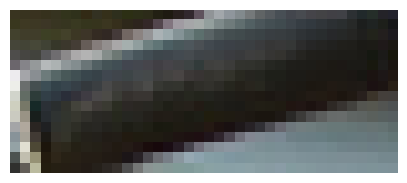

label:  18 , dog score:  0.9677563905715942
point_coords:  [[196.875, 293.75]]
generated:  a dog standing on top of a grass covered field . 


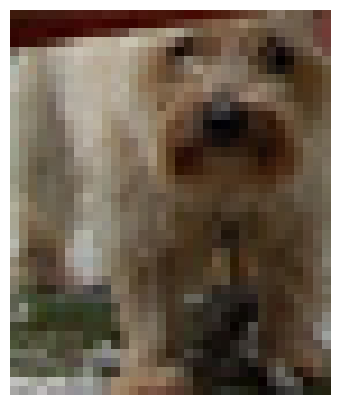

label:  8 , truck score:  0.9938992261886597
point_coords:  [[534.375, 181.25]]
generated:  a truck covered with a blue tarp in a field . 


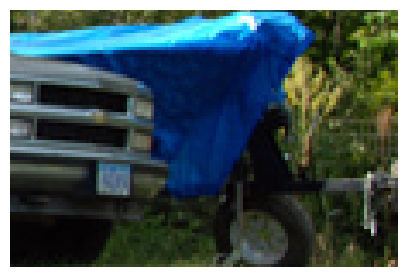

label:  2 , bicycle score:  0.5265945792198181
point_coords:  [[103.125, 68.75]]
generated:  a garage with a bicycle parked next to it . 


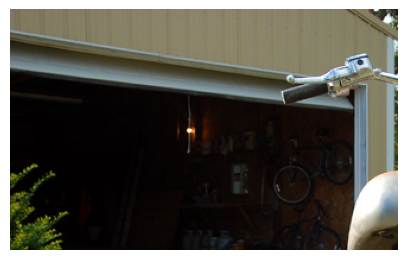

label:  2 , bicycle score:  0.9669137001037598
point_coords:  [[553.125, 281.25]]
generated:  a close up view of a bicycle tire . 


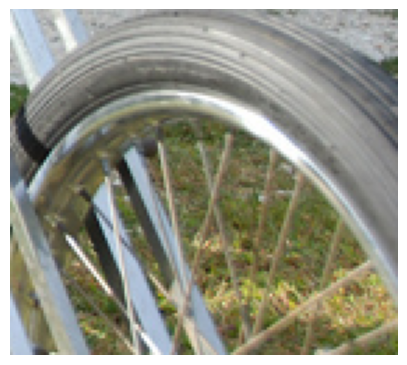

label:  4 , motorcycle score:  0.5102155804634094
point_coords:  [[571.875, 68.75]]
generated:  a close - up of a motor scooter with trees in the background . 


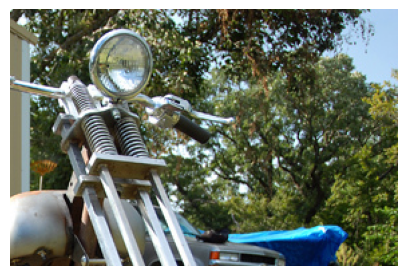

label:  11 , fire hydrant score:  0.9719631671905518
point_coords:  [[196.875, 343.75]]
generated:  a small dog standing next to fire hydrant . 


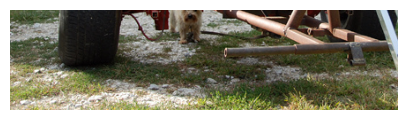

label:  4 , motorcycle score:  0.779170036315918
point_coords:  [[309.375, 243.75]]
generated:  a close - up of the back end of a motorcycle seat . 


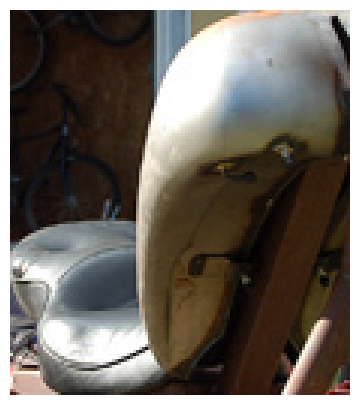

label:  4 , motorcycle score:  0.2922284007072449
point_coords:  [[234.375, 368.75]]
generated:  a blurry image of a car on the road . 


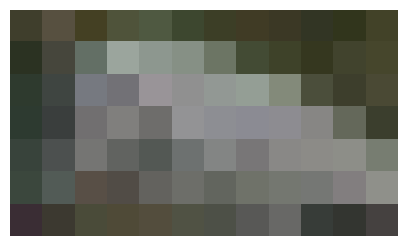

label:  55 , orange score:  0.9282946586608887
point_coords:  [[459.375, 193.75]]
generated:  an image of an orange and purple background . 


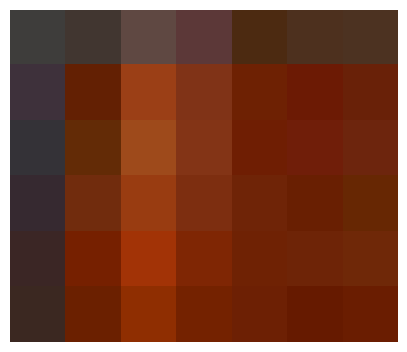

label:  2 , bicycle score:  0.9450063705444336
point_coords:  [[253.125, 193.75]]
generated:  a blurry picture of a bicycle in a room . 


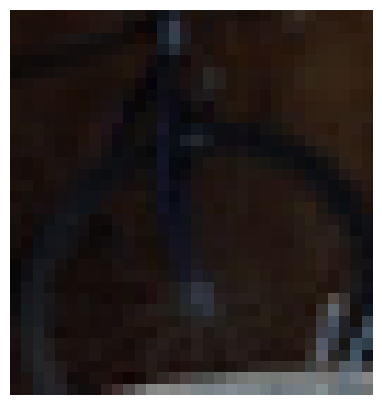

In [32]:
# print all the masks and their labels
for mask in range(len(label_dict)):
    check_label(mask)

In [33]:
def is_contained(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    return x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2

def postprocess(label_dict):
    result = []
    label_dict.sort(key=lambda x: x['bbox'][2] * x['bbox'][3])
    for i in range(len(label_dict)):
        keep = True
        for j in range(len(label_dict)):
            if i != j:
                if label_dict[i]['category_id'] == label_dict[j]['category_id']:
                    if is_contained(label_dict[i]['bbox'], label_dict[j]['bbox']) or label_dict[i]['score'] < label_dict[j]['score']:
                        keep = False
                        break
        if keep:
            result.append(label_dict[i])

    label_dict = result
    label_dict = [label for label in label_dict if label["score"] >= 0.6]
    return label_dict

label_dict = postprocess(label_dict)

label:  55 , orange score:  0.9282946586608887
point_coords:  [[459.375, 193.75]]
generated:  a blue tarp covering a truck parked on the side of the road . 


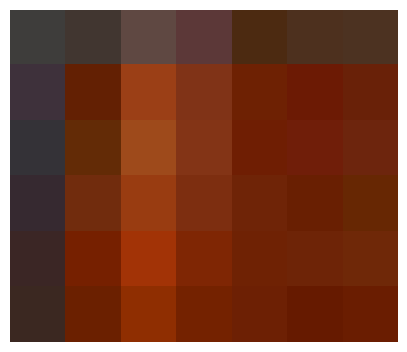

label:  85 , clock score:  0.9551718831062317
point_coords:  [[234.375, 156.25]]
generated:  a close - up view of a silver chair . 


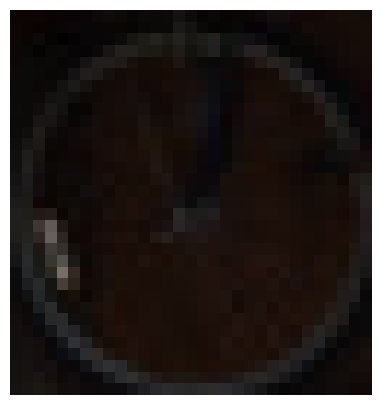

label:  18 , dog score:  0.9677563905715942
point_coords:  [[196.875, 293.75]]
generated:  an image of a clock with a dark background . 


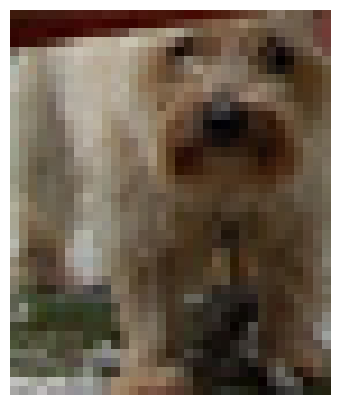

label:  62 , chair score:  0.8997074961662292
point_coords:  [[253.125, 243.75]]
generated:  a blurry image of a car in the middle of a road . 


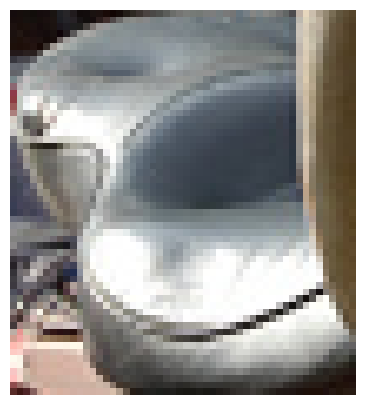

label:  8 , truck score:  0.9938992261886597
point_coords:  [[534.375, 181.25]]
generated:  a dog standing on top of a grass covered field . 


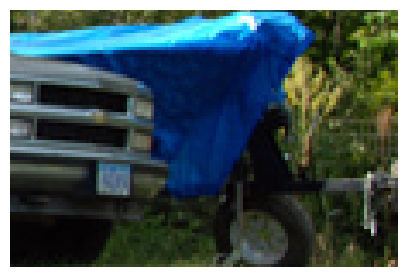

label:  4 , motorcycle score:  0.779170036315918
point_coords:  [[309.375, 243.75]]
generated:  a truck covered with a blue tarp in a field . 


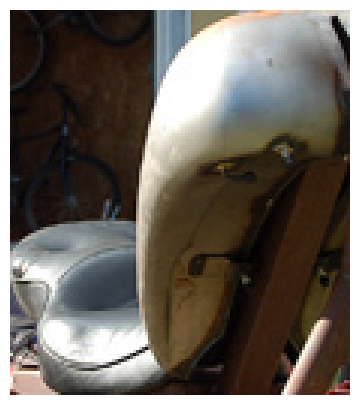

label:  2 , bicycle score:  0.9669137001037598
point_coords:  [[553.125, 281.25]]
generated:  a garage with a bicycle parked next to it . 


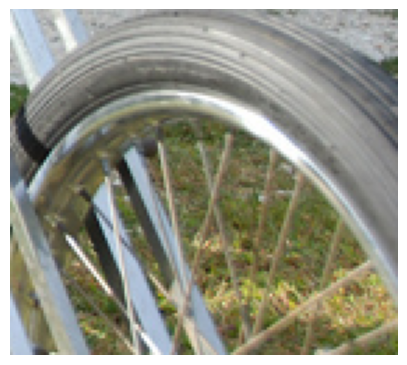

label:  11 , fire hydrant score:  0.9719631671905518
point_coords:  [[196.875, 343.75]]
generated:  a close up view of a bicycle tire . 


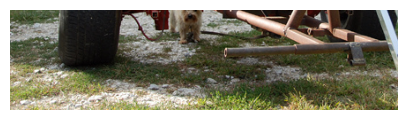

In [34]:
for mask in range(len(label_dict)):
    check_label(mask)

##### Step 5. If label is in COCO: compare prediction with ground truth score using mAP, Else: ignore

In [51]:
# import dependencies for COCO evaluation
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [52]:
annType = ['segm','bbox','keypoints']
annType = annType[1]      #specify type here
prefix = 'person_keypoints' if annType=='keypoints' else 'instances'
print('Running demo for *%s* results.'%(annType))

Running demo for *bbox* results.


In [53]:
#initialize COCO ground truth api
dataDir='../'
dataType='val2017'
prefix = 'instances'
annFile = '%s/coco/annotations/%s_%s.json'%(dataDir,prefix,dataType)
cocoGt=COCO(annFile)

loading annotations into memory...
Done (t=4.08s)
creating index...
index created!


In [71]:
# initialize COCO detections api
resFile='%s/coco/results/%s_%s_fake%s100_results.json'%(dataDir, prefix, dataType, annType)

# Read existing data from the file
with open(resFile, 'r') as f:
    data = json.load(f)

# Update data with new data
data.append(label_dict)

# Write updated data back to the file
with open(resFile, 'w') as f:
    json.dump(data, f)

# load results in COCO evaluation tool    
cocoDt=cocoGt.loadRes(resFile)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [57]:
imgIds=sorted(cocoGt.getImgIds())
imgIds=imgIds[0:100]
imgId = imgIds[np.random.randint(100)]

In [72]:
# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.32s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100